# Baseline Logistic

### Imports and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Evaluation metrics suitable for imbalanced classification
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)

df = pd.read_csv("../data/transactions.csv", parse_dates=["timestamp"])     # parse_dates ensures timestamps are treated as datetime objects


### Feature selection and target definition

In [2]:
# Selected features based on the EDA
features = [
    "amount",
    "night",
    "weekend",
    "country_change",
    "velocity",
    "device_risk",
]

# Feature matrix (X) and target vector (y)
X = df[features]
y = df["is_fraud"]   # Binary target: 1 = fraud, 0 = non-fraud


### Train–test split (with stratification)

In [3]:
# Split data into training and test sets
# Stratification preserves the fraud rate in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,      # 25% held out for evaluation
    random_state=42,     # Reproducibility
    stratify=y,          # Critical for imbalanced datasets
)


### Feature scaling

In [4]:
# Initialize standard scaler (Mean = 0, Std Dev = 1)
scaler = StandardScaler()


# Fit scaler only on training data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Feature scaling is required for logistic regression to ensure stable optimization and comparable coefficient magnitudes.


### Model definition and training

In [5]:
# Initialize logistic regression model
# class_weight='balanced' compensates for fraud rarity
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",    # Penalize misclassified frauds more
    random_state=42,
)

# Train the model on scaled training data
model.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### Predictions and probability estimates

In [6]:

y_pred = model.predict(X_test_scaled)                 # Predict class labels (0 or 1)
y_prob = model.predict_proba(X_test_scaled)[:, 1]     # Predict probability of the positive class (fraud)

roc_auc = roc_auc_score(y_test, y_prob)               # ROC-AUC measures ranking quality across thresholds
pr_auc = average_precision_score(y_test, y_prob)      # PR-AUC is more informative for rare-event detection

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")


ROC-AUC: 0.748
PR-AUC:  0.051


ROC-AUC measures ranking quality, while PR-AUC is more informative under strong class imbalance.


### Model evaluation (imbalanced-aware metrics)

In [7]:
# Detailed precision, recall and F1-score per class
print(classification_report(y_test, y_pred, digits=3))

# Error confusion to inspect false positives and false negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"True Negatives (Non-fraud correctly classified): {tn}")
print(f"False Positives (Legitimate transactions flagged as fraud): {fp}")
print(f"False Negatives (Missed fraud cases): {fn}")
print(f"True Positives (Fraud correctly detected): {tp}")


              precision    recall  f1-score   support

           0      0.993     0.710     0.828     29558
           1      0.033     0.665     0.063       442

    accuracy                          0.709     30000
   macro avg      0.513     0.687     0.445     30000
weighted avg      0.979     0.709     0.816     30000

True Negatives (Non-fraud correctly classified): 20974
False Positives (Legitimate transactions flagged as fraud): 8584
False Negatives (Missed fraud cases): 148
True Positives (Fraud correctly detected): 294


### Model interpretability (feature importance)

In [8]:
# Extract model coefficients
# Positive values increase fraud probability, while negative values decrease fraud probability
coefficients = pd.Series(
    model.coef_[0],
    index=features,
).sort_values()

coefficients


weekend           0.037458
amount            0.226347
country_change    0.238655
night             0.239306
device_risk       0.547069
velocity          0.583554
dtype: float64

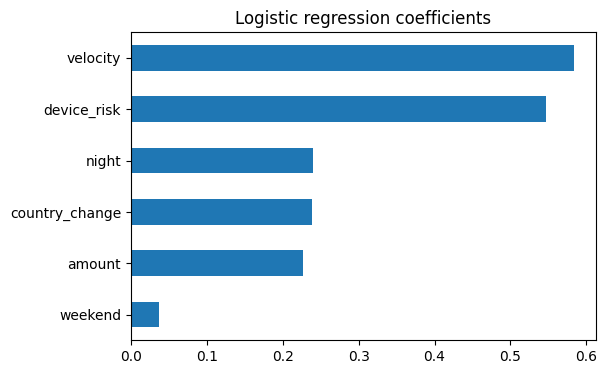

In [9]:
# Visualize coefficients for interpretability
coefficients.plot(kind="barh", figsize=(6, 4))

plt.title("Logistic regression coefficients")
plt.show()


Positive coefficients increase fraud risk, while negative ones reduce it. Amount, country change, and velocity are among the strongest signals.


## Baseline Model Summary

In this section, we develop a first baseline model for transaction fraud detection using logistic regression.
The purpose of this model is not to achieve maximum predictive performance, but to establish a solid, interpretable reference that reflects best practices for highly imbalanced classification problems.

---

### Problem framing

Fraud detection is a rare-event classification task, with fraudulent transactions representing approximately 1–2% of all observations.
This strong class imbalance requires careful modeling choices, as standard accuracy metrics and naive modeling approaches can produce misleading results.

---

### Model selection

Logistic regression is chosen as the baseline model due to its simplicity, robustness, and interpretability.
The model estimates the probability that a transaction is fraudulent given a set of explanatory variables, allowing downstream decisions to be made by adjusting classification thresholds according to business needs.

Despite its simplicity, logistic regression often performs competitively in fraud detection tasks and serves as a strong benchmark for more complex models.

---

### Handling class imbalance

To properly address the imbalance in the target variable:
- A stratified train–test split is used to preserve the fraud rate in both training and evaluation sets.
- Class weights are adjusted during training to penalize misclassification of fraudulent transactions more heavily.

These steps prevent the model from collapsing into trivial predictions dominated by the majority class.

---

### Feature preprocessing

Numerical features are standardized prior to training to ensure stable optimization and to make coefficient magnitudes comparable.
To avoid data leakage, scaling parameters are learned exclusively from the training set and then applied to the test set.

---

### Evaluation strategy

Model performance is evaluated using metrics that are appropriate for imbalanced classification:

- **Receiver Operating Characteristic - Area Under the Curve (ROC-AUC)** is used to assess the model’s ability to rank fraudulent transactions above legitimate ones across a range of thresholds.

- **Precision Recall - Area Under the Curve (PR-AUC)** is emphasized as a more informative metric in rare-event settings, as it directly reflects the trade-off between precision and recall among flagged transactions. In one hand, precision corresponds to the proportion of correctly identified transactions as fraudulent from all of the ones being labeled as such. In the other hand, recall is the proportion of fraudulent transcations that haven't been labeled from the total number of frauds.

These metrics provide a more meaningful assessment than overall accuracy in the context of fraud detection.

---

### Interpretability and insights

A key advantage of logistic regression is its interpretability.
The learned coefficients provide direct insight into how each feature influences fraud risk, enabling validation of the model against domain intuition. The higher those coefficients are, the more they are able to predict the probability of some transaction being fraudulent.

Signals such as transaction amount, cross-border activity, and transaction velocity emerge as meaningful contributors to fraud risk, consistent with real-world patterns.

---

### Conclusion

This baseline model establishes a transparent and principled foundation for fraud detection.
It demonstrates appropriate handling of class imbalance, the use of meaningful evaluation metrics, and the importance of interpretability.
The results obtained here serve as a reference point for subsequent improvements through feature engineering and more advanced modeling techniques.
